In [2]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
train_df = pd.read_csv('../dump/train_modified_label.csv')
test_df = pd.read_csv('../dump/test_modified_label.csv')
label = pd.read_csv('../input/test_label.csv')

In [8]:
target='acc_now_delinq'
IDcol = 'member_id'
print(train_df.shape, test_df.shape, label.shape)

(709903, 82) (177476, 81) (177476, 2)


In [11]:
train_df.columns

Index(['acc_now_delinq', 'all_util', 'annual_inc', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'dti', 'emp_length', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'il_util', 'inq_fi', 'inq_last_12m',
       'installment', 'int_rate', 'loan_amnt', 'max_bal_bc', 'member_id',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m', 'open_il_24m',
       'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'out_prncp',
       'out_prncp_inv', 'policy_code', 'pub_rec', 'recoveries', 'revol_bal',
       'revol_util', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_acc', 'total_bal_il', 'total_cu_tl', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'total_rev_hi_lim', 'loan_status_0', 'loan_status_1',
       'loan_status_2', 'loan_status_3', 'loan_status_4', 'loan_status_5',
       'loan_status_6', 'loan_status_7', 'loan_status_8', 'loan_s

In [9]:
# submission = pd.read_csv('../input/sample_submission.csv')
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['acc_now_delinq'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['acc_now_delinq'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['acc_now_delinq'], dtrain_predprob))
    print(metrics.classification_report(dtrain['acc_now_delinq'], dtrain_predictions))
    
#     Predict on testing data:
    dtest_predprob  = alg.predict_proba(dtest[predictors])[:,1]
    dtest_predictions = alg.predict(dtest[predictors])
#     submission = submission.merge(dtest[[IDcol,target]], on=IDcol)
    print('AUC Score (Test): %f' % metrics.roc_auc_score(label['acc_now_delinq'], dtest_predprob))
    print("Fbeta_score(Test):%.4g"% metrics.fbeta_score(label['acc_now_delinq'].values, dtest_predictions, beta = 2))
    print(metrics.classification_report(label['acc_now_delinq'], dtest_predictions))
                
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-auc:0.758916+0.0108178	test-auc:0.748545+0.0115792
[1]	train-auc:0.779664+0.00797507	test-auc:0.77133+0.0167697
[2]	train-auc:0.79341+0.00712927	test-auc:0.785796+0.011369
[3]	train-auc:0.796213+0.0065087	test-auc:0.787771+0.0133469
[4]	train-auc:0.806655+0.00308188	test-auc:0.799269+0.0102945
[5]	train-auc:0.810229+0.00230396	test-auc:0.802889+0.0102936
[6]	train-auc:0.812335+0.00462899	test-auc:0.804286+0.00967988
[7]	train-auc:0.815851+0.00473355	test-auc:0.806568+0.00964592
[8]	train-auc:0.820215+0.00286457	test-auc:0.811777+0.00942715
[9]	train-auc:0.821736+0.00209033	test-auc:0.81156+0.0100114
[10]	train-auc:0.827254+0.00267331	test-auc:0.815928+0.0096017
[11]	train-auc:0.829203+0.00388545	test-auc:0.816846+0.00737107
[12]	train-auc:0.830571+0.00449256	test-auc:0.817738+0.00744622
[13]	train-auc:0.832295+0.00564961	test-auc:0.818733+0.00828098
[14]	train-auc:0.833696+0.00587222	test-auc:0.819176+0.00817083
[15]	train-auc:0.835224+0.00584985	test-auc:0.821084+0.00594249


[129]	train-auc:0.930481+0.000976526	test-auc:0.880261+0.00521929
[130]	train-auc:0.930799+0.00106559	test-auc:0.880345+0.00520317
[131]	train-auc:0.931161+0.00100071	test-auc:0.880433+0.00518801
[132]	train-auc:0.931718+0.0009942	test-auc:0.880622+0.00519337
[133]	train-auc:0.932228+0.000998252	test-auc:0.880788+0.00519888
[134]	train-auc:0.93255+0.000957384	test-auc:0.880844+0.00520274
[135]	train-auc:0.932823+0.000963871	test-auc:0.880943+0.00520258
[136]	train-auc:0.933244+0.00103774	test-auc:0.880951+0.0052482
[137]	train-auc:0.933577+0.00111858	test-auc:0.880972+0.00525847
[138]	train-auc:0.933976+0.00117096	test-auc:0.881076+0.00525206
[139]	train-auc:0.934312+0.00116654	test-auc:0.88106+0.00519466
[140]	train-auc:0.934527+0.00110341	test-auc:0.881061+0.00518434
[141]	train-auc:0.934926+0.00115223	test-auc:0.881086+0.00516114
[142]	train-auc:0.935147+0.00113265	test-auc:0.88117+0.00526852
[143]	train-auc:0.935402+0.00107856	test-auc:0.881153+0.00529426
[144]	train-auc:0.935685+0

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9965
AUC Score (Train): 0.935373
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    706610
        1.0       0.92      0.27      0.42      3293

avg / total       1.00      1.00      1.00    709903



D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC Score (Test): 0.871326
Fbeta_score(Test):0.2841
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    176655
          1       0.85      0.24      0.38       821

avg / total       1.00      1.00      1.00    177476



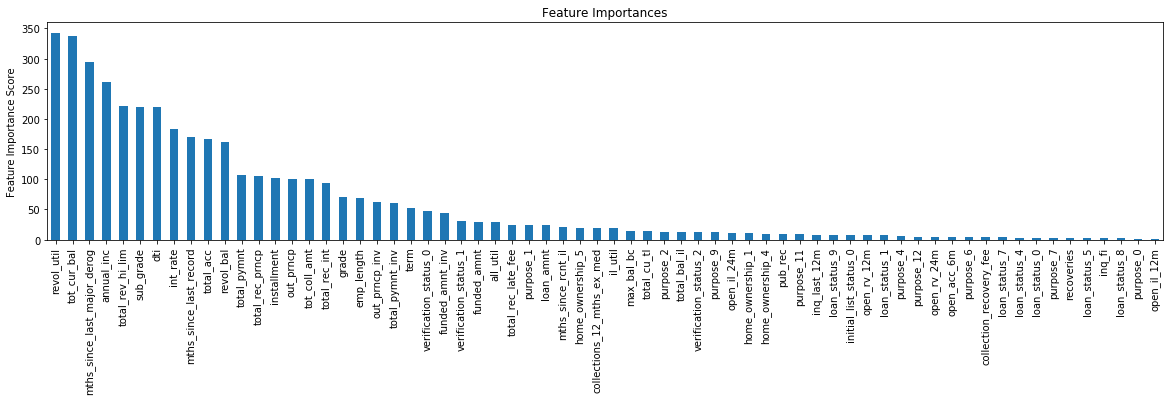

In [12]:
predictors = [x for x in train_df.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_df, test_df, predictors)

In [13]:
dtrain_predictions = xgb1.predict(train_df[predictors])
dtest_predictions = xgb1.predict(test_df[predictors])
#     Predict on testing data:
dtrain_predprob = xgb1.predict_proba(train_df[predictors])[:,1]
dtest_predprob = xgb1.predict_proba(test_df[predictors])[:,1]

#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(train_df['acc_now_delinq'].values, dtrain_predictions))
print("Recall:%.4g"% metrics.accuracy_score(train_df['acc_now_delinq'].values, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(train_df['acc_now_delinq'], dtrain_predprob))
print("AUC Score (Test): %f" % metrics.roc_auc_score(label['acc_now_delinq'], dtest_predprob))

print("Fbeta_score(Train):%.4g"% metrics.fbeta_score(train_df['acc_now_delinq'].values, dtrain_predictions, beta = 2))
print("Fbeta_score(Test):%.4g"% metrics.fbeta_score(label['acc_now_delinq'].values, dtest_predictions, beta = 2))


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9965
Recall:0.9965
AUC Score (Train): 0.935373
AUC Score (Test): 0.871326
Fbeta_score(Train):0.317
Fbeta_score(Test):0.2841


In [14]:
def f2_score(preds, label):  # preds是结果（概率值），dtrain是个带label的DMatrix
    beta = 2

    # preds = 1.0 / (1.0 + np.exp(-preds))
    pred = [int(i >= 0.3) for i in preds]

    precision = metrics.precision_score(label,pred)
    recall = metrics.recall_score(label,pred)

    return 'f2_score', ((np.square(beta)+1)*precision * recall / (np.square(beta)*precision + recall))

In [15]:
f2_score(dtest_predprob, label['acc_now_delinq'])

('f2_score', 0.2862000566732786)

In [35]:
_

Text(0.5,1,'2-class Precision-Recall curve:')

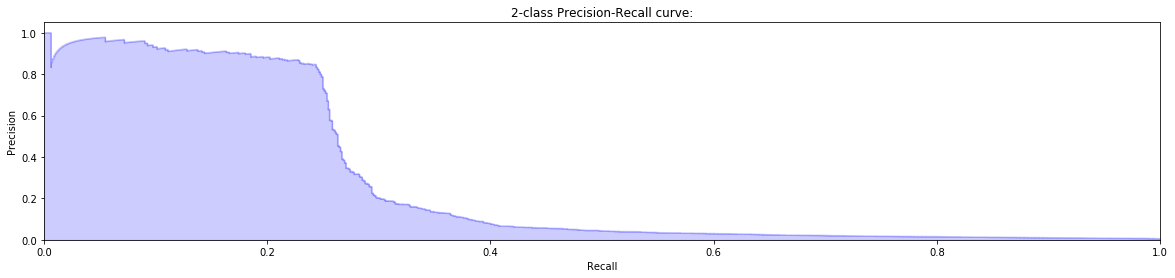

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(label['acc_now_delinq'], dtest_predprob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve:')

In [ ]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':np.arange(3,10,2),
    'min_child_weight':np.arange(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(train_df[predictors],train_df[target])

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
y_score = alg.decision_function(X_test)

In [11]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, dtest['predprob'])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

NameError: name 'y_test' is not defined